In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

try:
    from ImageDataAugmentor.image_data_augmentor import *
except:
    import sys
    sys.path.append("..")
    from ImageDataAugmentor.image_data_augmentor import *
    
import tensorflow as tf

In [2]:
SEED = 123
EPOCHS = 10
BATCH_SIZE = 32

## Data loading

In [3]:
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

In [4]:
# load mnist data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[...,None]/255.
x_test = x_test[...,None]/255.
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size=0.25,
                                                  random_state=SEED)

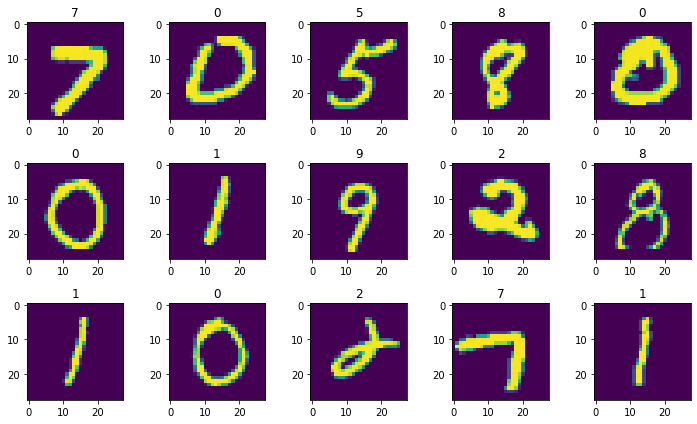

In [5]:
# visualize some items in the dataset
rows, cols = 3, 5
plt.figure(figsize=(2*cols, 2*rows))
for idx in range(rows*cols):
    plt.subplot(rows, cols, idx+1)
    plt.imshow(x_train[idx])
    plt.title(y_train[idx])
plt.tight_layout()
plt.show()

## Datagenerators

In [6]:
# augmentations
AUGMENTATIONS = albumentations.Compose([
    albumentations.GaussNoise(var_limit=(0.,.1),
                              mean=0.,
                              p=1,
                             )
])

In [7]:
# dataloaders
dg = ImageDataAugmentor(augment=AUGMENTATIONS, )
training_generator = dg.flow(x_train, x_train, batch_size=BATCH_SIZE, shuffle=True)
validation_generator = dg.flow(x_val, x_val, batch_size=BATCH_SIZE, shuffle=True)

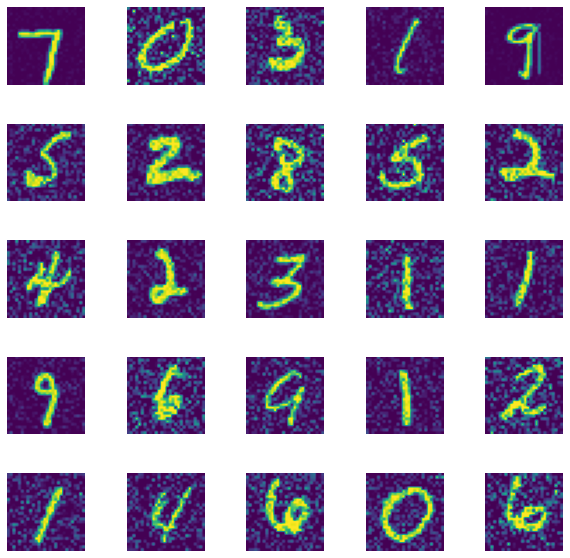

In [8]:
# visualize augmented images
training_generator.show_data()

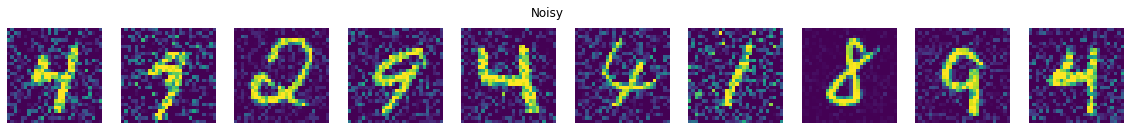

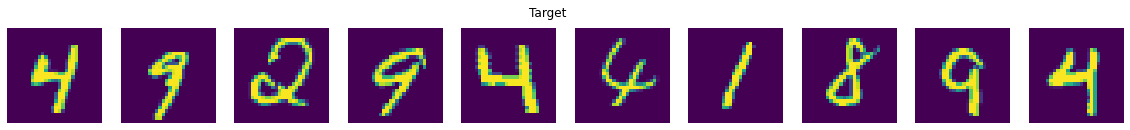

In [9]:
# show inputs and targets
imgs, targets = training_generator.__getitem__(0)
rows, cols = 1, 10

plt.figure(figsize=(2*cols, 2*rows))
for i in range(cols*rows):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i])
    plt.axis('off')
plt.suptitle('Noisy')
plt.show()

plt.figure(figsize=(2*cols, 2*rows))
for i in range(cols*rows):
    plt.subplot(rows, cols, i+1)
    plt.imshow(targets[i])
    plt.axis('off')
plt.suptitle('Target')
plt.show()

## Denoiser model

In [10]:
from tensorflow.keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, UpSampling2D
from tensorflow.keras.models import Model

In [11]:
# Encoder 
inputs = Input(shape=(28,28,1))
x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = MaxPool2D()(x)
x = Dropout(0.3)(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
encoded = MaxPool2D()(x)

# Decoder
x = Conv2D(32, 3, activation='relu', padding='same')(encoded)
x = UpSampling2D()(x)
x = Dropout(0.3)(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = UpSampling2D()(x)
decoded = Conv2D(1, 3, activation='sigmoid', padding='same')(x)

denoiser = Model(inputs, decoded, name='digit-denoiser')
denoiser.compile(optimizer='adam', loss='binary_crossentropy')
denoiser.summary()

Model: "digit-denoiser"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)       

In [12]:
def plot_training_statistics(history,):
    epochs = [i for i in range(1, len(history['loss'])+1)]

    plt.figure(figsize=(16,6))
    keys = history.keys()
    keys = [key for key in keys if not "lr" in key and not "val_" in key]
    
    for idx, key in enumerate(keys):
        plt.subplot(1, len(keys), idx+1)
        plt.plot(epochs, history[key], label="training_"+key)
        plt.plot(epochs, history['val_'+key], label="validation_"+key)
        plt.legend(loc='best')
        plt.title(key)
        plt.xlabel('epoch')
        
    plt.show()
    plt.close('all')

Epoch 1/10
1407/1407 [==============================] - 51s 36ms/step - loss: 0.1552 - val_loss: 0.0811
Epoch 2/10
1407/1407 [==============================] - 55s 39ms/step - loss: 0.0866 - val_loss: 0.0779
Epoch 3/10
1407/1407 [==============================] - 55s 39ms/step - loss: 0.0832 - val_loss: 0.0765
Epoch 4/10
1407/1407 [==============================] - 58s 41ms/step - loss: 0.0816 - val_loss: 0.0759
Epoch 5/10
1407/1407 [==============================] - 55s 39ms/step - loss: 0.0808 - val_loss: 0.0760
Epoch 6/10
1407/1407 [==============================] - 57s 40ms/step - loss: 0.0802 - val_loss: 0.0752
Epoch 7/10
1407/1407 [==============================] - 56s 40ms/step - loss: 0.0798 - val_loss: 0.0756
Epoch 8/10
1407/1407 [==============================] - 56s 39ms/step - loss: 0.0797 - val_loss: 0.0751
Epoch 9/10
1407/1407 [==============================] - 58s 41ms/step - loss: 0.0792 - val_loss: 0.0748
Epoch 10/10
1407/1407 [==============================] - 55s 39m

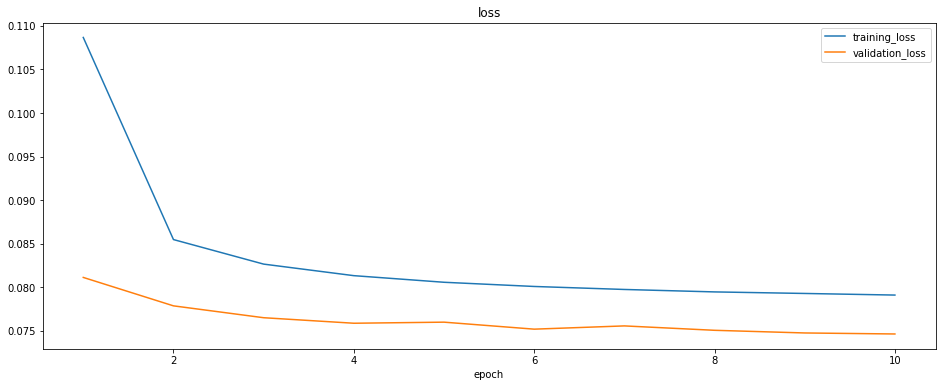

In [13]:
# train the model
history = denoiser.fit(training_generator,
                       steps_per_epoch=len(training_generator),
                       epochs=EPOCHS,
                       validation_data=validation_generator,
                       validation_steps=len(validation_generator),
                       shuffle=False,
                      )
plot_training_statistics(history.history)

## Inference

In [14]:
# test data
test_generator = dg.flow(x_test, x_test, batch_size=BATCH_SIZE, shuffle=True)

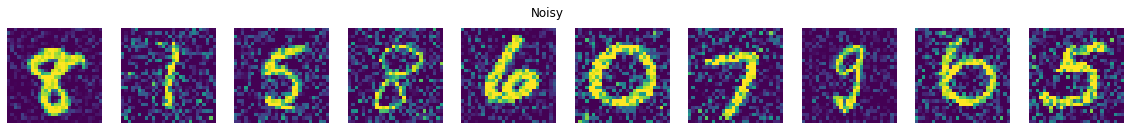

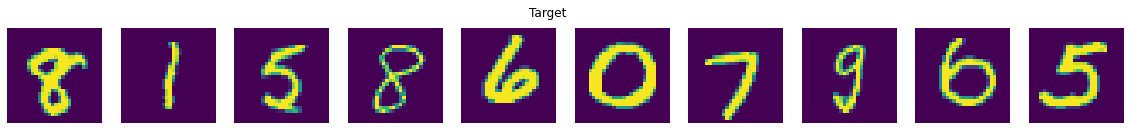

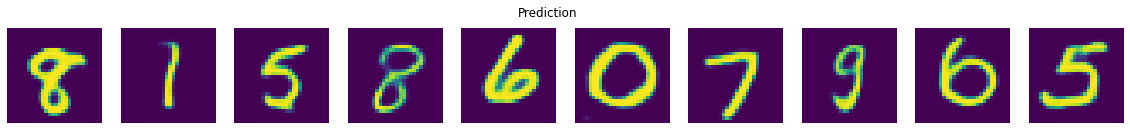

In [15]:
# show input, target and prediction
imgs, targets = test_generator.__getitem__(0)
preds = denoiser.predict(imgs)

rows, cols = 1, 10
plt.figure(figsize=(2*cols, 2*rows))
for i in range(cols*rows):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i])
    plt.axis('off')
plt.suptitle('Noisy')
plt.show()

plt.figure(figsize=(2*cols, 2*rows))
for i in range(cols*rows):
    plt.subplot(rows, cols, i+1)
    plt.imshow(targets[i])
    plt.axis('off')
plt.suptitle('Target')
plt.show()

plt.figure(figsize=(2*cols, 2*rows))
for i in range(cols*rows):
    plt.subplot(rows, cols, i+1)
    plt.imshow(preds[i])
    plt.axis('off')
plt.suptitle('Prediction')
plt.show()